# NearestNeighbors classifier on MNist data set - multi machine execution using dask

## Task 1 - Load the Mnist data set

In [13]:
%%time
from keras.datasets import mnist

# split data into training and testing 60000/10000
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(len(x_train))
print(len(x_test))
print(x_train.shape)
print(x_test.shape)
print(y_train[0:10])

60000
10000
(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
CPU times: user 244 ms, sys: 8.02 ms, total: 252 ms
Wall time: 315 ms


## Task 2 - Pre-proccessing of dataset

(10000, 28, 28)
(60000, 28, 28)
processing time in ms:  78.20963859558105


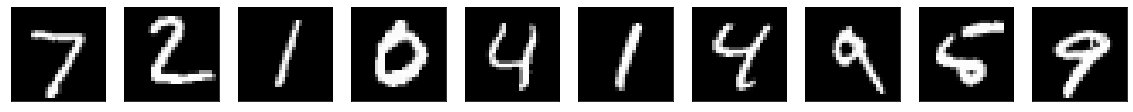

In [14]:
import sys
import time
sys.path.append('../')
from Utils.Utils import Utils

start_time = time.time()
# Recaculate values so result is normalized between 0-1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test  /= 255
print(x_test.shape)
print(x_train.shape)
x_train = x_train.reshape([60000,784])
x_test = x_test.reshape([10000,784])

end_time = time.time()

preprocessing_time = end_time-start_time
print(f"processing time in ms:  {preprocessing_time*1000}")
# print examples
util_provider = Utils()
util_provider.show_imgs(x_test, 28)

## Task 3 - Training

In [17]:
import numpy as np
from sklearn import neighbors

#Start timer
start_time = time.time()
model = neighbors.KNeighborsClassifier(n_neighbors=8, weights='uniform')

# Fit model
model.fit(x_train, y_train)
print(f"size of model {sys.getsizeof(model)}")

end_time = time.time()
training_time = end_time-start_time
print(f"training_time time in ms:  {training_time*1000}")

size of model 48
training_time time in ms:  27.451276779174805


### Setup connection to kubernetes dask cluster 

In [19]:
from dask.distributed import Client
# 10.42.0.165 is the virtuel ip of the dask scheduler within the kubernetes cluster
client = Client("10.42.0.34:8786")
client

<Client: 'tcp://10.42.0.34:8786' processes=10 threads=10, memory=190.88 GiB>

## Task 4 - Model evaluation

In [21]:
%%time
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask
from dask.diagnostics import visualize


@dask.delayed
def predict(model, x_test_chunk, y_test_chunk):
    return model.score(x_test_chunk, y_test_chunk)

@dask.delayed
def mean_score(scores, chunk_size):
    return sum(scores)/chunk_size


number_of_dask_workers = 10

tasks_delayed = []
prev_i = 0
for i in range(1000,11000,1000):
    x_test_chunk = x_test[prev_i:i]
    y_test_chunk = y_test[prev_i:i]
    prev_i = i
    tasks_delayed.append(predict(model,x_test_chunk,y_test_chunk))
    
mean_delayed = mean_score(tasks_delayed, number_of_dask_workers)
    
mean_delayed.visualize()

aggregated_mean_score = mean_delayed.compute()
print(aggregated_mean_score)

0.9669999999999999
CPU times: user 1.15 s, sys: 2.56 s, total: 3.71 s
Wall time: 24.8 s


In [6]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask
from dask.diagnostics import visualize

number_of_dask_workers = 10

#Start timer
start_time = time.time()

# create dask partions
combined_array = [(value, y_test[i])  for i, value in enumerate(x_test)]
#partion_array = [chunks(combined_array, 2)]

def acum(numbers):
    print("calling acum")
    print("calling acum")
    print("calling acum")
    acum =0
    for num in numbers:
        acum +=num
    
    return acum
#prepared_chunks = da.from_array(combined_array, chunks=(1000,2))
#bag = db.from_sequence(combined_array, npartitions=10)

#data_futures = client.scatter([combined_array[0:1000], combined_array[1000:2000], combined_array[2000:3000]], broadcast=True)
data_futures = client.scatter([combined_array[0:5000], combined_array[5000:10000]], broadcast=True)
model_futures = client.scatter([model, model], broadcast=True)

for future in data_futures:
    print(len(future.result()))


def evaluate_chunk(chunk, model):
    print("is called")
    #items = zip(*bag)
    #count = 0
    #for item in bag:      
    #    if count == 3:
    #        break
    #    print(f"Current item : {count}")
    #    count = count + 1
    x_test = [item[0] for item in chunk]
    y_test = [item[1] for item in chunk]
    successRate = model.score(x_test, y_test)
    return successRate
    

result_futures = [client.submit(evaluate_chunk, data_futures[i], model_futures[i]) for i in range(2)]

mean = (result_futures[0].result() + result_futures[1].result())/2 

print(f"mean result : {mean}")    
#result = bag.map(evaluate_chunk).mean()
#result.visualize("NNC_task_graph.png")    
    
#succes_rate  = result.compute()    
#print(succes_rate)
    
#task = daskBag.map(countChars
#                     ).sum()
#print(dask_x_test_chunks.chunks)

#successRate = model.score(x_test, y_test)

#end timer
end_time = time.time()
eval_time = end_time-start_time
print(f"evaluation time in ms:  {eval_time*1000}")
#print(f"Success rate: {successRate*100}%")

KeyboardInterrupt: 